Starting Minority Game Simulation...
Parameters: m=5, s=2, iterations=1000, equilibrium period=200

=== Simulation Started ===

Memory Size (m): 5, Strategies per Agent (s): 2
Total Iterations: 1000, Warm-up Period: 200

Simulating for N = 21 agents...
  2^m/N = 1.524
  Scaled Variance (σ²/N): 0.0782 ± 0.0096
  Average Buyers: 10.4, Last Buyers: 10.6

Simulating for N = 36 agents...
  2^m/N = 0.889
  Scaled Variance (σ²/N): 0.0034 ± 0.0023
  Average Buyers: 18.0, Last Buyers: 18.0

Simulating for N = 51 agents...
  2^m/N = 0.627
  Scaled Variance (σ²/N): 0.0619 ± 0.0031
  Average Buyers: 25.5, Last Buyers: 25.4

Simulating for N = 66 agents...
  2^m/N = 0.485
  Scaled Variance (σ²/N): 0.0032 ± 0.0015
  Average Buyers: 33.0, Last Buyers: 33.0

Simulating for N = 81 agents...
  2^m/N = 0.395
  Scaled Variance (σ²/N): 0.0579 ± 0.0045
  Average Buyers: 40.5, Last Buyers: 39.2

Simulating for N = 96 agents...
  2^m/N = 0.333
  Scaled Variance (σ²/N): 0.0126 ± 0.0098
  Average Buyers: 48.0, 

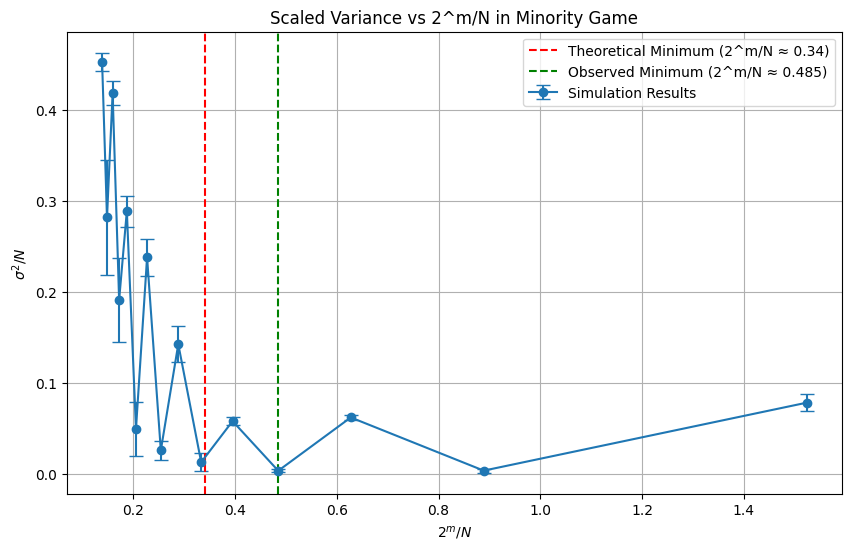

In [8]:
import numpy as np
import matplotlib.pyplot as plt


class Strategy:
    """
    Represents a single strategy for an agent.
    """
    def __init__(self, m):
        self.m = m
        self.predictions = np.random.choice([-1, 1], size=(2**m,))  # Random actions for all states

    def predict(self, state):
        """
        Predict the action (-1 or 1) based on the current state.
        """
        return self.predictions[state]


class Agent:
    """
    Represents an agent in the Minority Game.
    """
    def __init__(self, m, s):
        self.m = m
        self.s = s
        self.strategies = [Strategy(m) for _ in range(s)]  # Each agent has s strategies
        self.virtual_scores = np.zeros(s)  # Virtual scores for each strategy
        self.real_score = 0  # Real score for the agent

    def choose_action(self, state):
        """
        Choose the action based on the strategy with the highest virtual score.
        If scores are tied, choose randomly among the best.
        """
        max_score = np.max(self.virtual_scores)
        best_indices = [i for i, score in enumerate(self.virtual_scores) if score == max_score]
        chosen_strategy_idx = np.random.choice(best_indices)
        action = self.strategies[chosen_strategy_idx].predict(state)
        return action, chosen_strategy_idx


class MinorityGame:
    """
    Simulates the Minority Game.
    """
    def __init__(self, m=5, s=2, iter=1000, iteq=200):
        self.m = m  # Memory size
        self.s = s  # Number of strategies per agent
        self.iter = iter  # Total number of iterations
        self.iteq = iteq  # Warm-up iterations before collecting statistics

    def simulate_once(self, N):
        """
        Run a single simulation for a given number of agents N.
        """
        agents = [Agent(self.m, self.s) for _ in range(N)]
        state = 0  # Initial state
        buyers_count = []  # Record the number of buyers at each iteration

        for t in range(self.iter):
            actions = []
            for agent in agents:
                action, strategy_idx = agent.choose_action(state)
                actions.append(action)
            
            buyers = np.sum(np.array(actions) == 1)  # Count buyers
            excess_demand = 2 * buyers - N  # Compute excess demand

            # Update scores for each agent
            for i, agent in enumerate(agents):
                for j in range(self.s):
                    prediction = agent.strategies[j].predict(state)
                    agent.virtual_scores[j] += -prediction * excess_demand / N
                
                agent.real_score += -actions[i] * excess_demand / N

            # Update the state based on excess demand
            state = (((state << 1) & ((2**self.m)-1)) | (1 if excess_demand > 0 else 0))

            # Collect statistics after the warm-up period
            if t >= self.iteq:
                buyers_count.append(buyers)

        # Compute variance of the number of buyers
        variance = np.var(buyers_count)
        return variance, buyers_count[-1], np.mean(buyers_count)

    def run_simulation(self):
        """
        Run simulations for a range of N values and collect statistics.
        """
        N_values = np.linspace(21, 231, 15).astype(int)  # Adjust step size for faster computation
        nsam = 10  # Number of samples for each N

        results = []
        errors = []
        x_values = []

        print("\n=== Simulation Started ===\n")
        print(f"Memory Size (m): {self.m}, Strategies per Agent (s): {self.s}")
        print(f"Total Iterations: {self.iter}, Warm-up Period: {self.iteq}\n")

        for N in N_values:
            print(f"Simulating for N = {N} agents...")
            variances = []
            avg_buyers_list = []
            last_buyers_list = []

            for sample in range(nsam):
                variance, last_buyers, avg_buyers = self.simulate_once(N)
                variances.append(variance / N)
                avg_buyers_list.append(avg_buyers)
                last_buyers_list.append(last_buyers)
            
            mean_variance = np.mean(variances)
            std_variance = np.std(variances) / np.sqrt(nsam)
            mean_avg_buyers = np.mean(avg_buyers_list)
            mean_last_buyers = np.mean(last_buyers_list)
            
            results.append(mean_variance)
            errors.append(std_variance)
            x_value = 2**self.m / N
            x_values.append(x_value)

            print(f"  2^m/N = {x_value:.3f}")
            print(f"  Scaled Variance (σ²/N): {mean_variance:.4f} ± {std_variance:.4f}")
            print(f"  Average Buyers: {mean_avg_buyers:.1f}, Last Buyers: {mean_last_buyers:.1f}\n")

        print("\n=== Simulation Summary ===")
        print(f"Theoretical Optimal 2^m/N: 0.34")
        min_index = np.argmin(results)
        print(f"Observed Optimal 2^m/N: {x_values[min_index]:.3f}")
        print(f"Minimum Scaled Variance: {results[min_index]:.4f} ± {errors[min_index]:.4f}")

        self.plot_results(x_values, results, errors)
        return x_values, results, errors

    def plot_results(self, x_values, results, errors):
        """
        Plot the results of the simulation.
        """
        plt.figure(figsize=(10, 6))
        plt.errorbar(x_values, results, yerr=errors, fmt='o-', capsize=5, label="Simulation Results")
        plt.axvline(x=0.34, color='r', linestyle='--', label='Theoretical Minimum (2^m/N ≈ 0.34)')
        min_index = np.argmin(results)
        plt.axvline(x=x_values[min_index], color='g', linestyle='--', 
                   label=f'Observed Minimum (2^m/N ≈ {x_values[min_index]:.3f})')
        plt.xlabel(r'$2^m / N$')
        plt.ylabel(r'$\sigma^2 / N$')
        plt.title('Scaled Variance vs 2^m/N in Minority Game')
        plt.legend()
        plt.grid(True)
        plt.show()


def main():
    np.random.seed(42)
    print("Starting Minority Game Simulation...")
    print(f"Parameters: m=5, s=2, iterations=1000, equilibrium period=200")
    
    game = MinorityGame(m=5, s=2, iter=1000, iteq=200)
    game.run_simulation()


if __name__ == "__main__":
    main()